In [381]:
import re
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import nltk
from spellchecker import SpellChecker
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from yellowbrick.text.freqdist import FreqDistVisualizer 

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [382]:
#!pip install pyspellchecker

In [383]:
# dataset is taken from Kaggle
df_tweet = pd.read_csv('./dataset/train.csv')

# Note: this df does not have the target column
df_test = pd.read_csv('./dataset/test.csv')

In [384]:
print('There are {} rows and {} columns in the training dataset'.
      format(df_tweet.shape[0],df_tweet.shape[1]))

print('There are {} rows and {} columns in the testing dataset'.
      format(df_test.shape[0],df_test.shape[1]))

There are 7613 rows and 5 columns in the training dataset
There are 3267 rows and 4 columns in the testing dataset


In [385]:
# train data
df_tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [386]:
# test data . Note: it does not have target column and just can be used for testing
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [387]:
print('missing values of the keyword column: {}/{} ({}%)'.
      format(df_tweet.keyword.isna().sum(),len(df_tweet),
             round((df_tweet.keyword.isna().sum() / len(df_tweet)) * 100,2)))

print('missing values of the location column: {}/{} ({}%)'.
      format(df_tweet.location.isna().sum(), len(df_tweet),
             round((df_tweet.location.isna().sum() / len(df_tweet)) * 100,2)))

missing values of the keyword column: 61/7613 (0.8%)
missing values of the location column: 2533/7613 (33.27%)


In [388]:
print('class 0: {} cases'.format(df_tweet.target.value_counts()[0]))
print('class 1: {} cases'.format(df_tweet.target.value_counts()[1]))

class 0: 4342 cases
class 1: 3271 cases


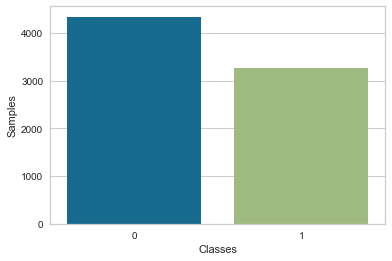

In [389]:
# the number of classes are almost balanced. So, we do not need to balance them.
# However, there are more tweets with class 0 (No disaster) than class 1 (disaster tweets)
target_counts = df_tweet.target.value_counts()
sns.barplot(target_counts.index,target_counts)
plt.gca().set_ylabel('Samples')
plt.gca().set_xlabel('Classes')
plt.show();

### Number of characters in tweets

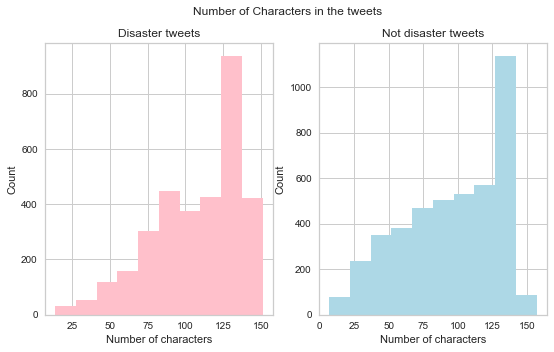

In [390]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,5))

tweet_disaster_len=df_tweet[df_tweet.target == 1]['text'].str.len()
ax1.hist(tweet_disaster_len,color='pink')
ax1.set_title('Disaster tweets')
ax1.set_xlabel('Number of characters')
ax1.set_ylabel('Count')

tweet_not_disaster_len=df_tweet[df_tweet.target == 0]['text'].str.len()
ax2.hist(tweet_not_disaster_len,color='lightblue')
ax2.set_title('Not disaster tweets')
ax2.set_xlabel('Number of characters')
ax2.set_ylabel('Count')

fig.suptitle('Number of Characters in the tweets')
plt.show();

### Number of words in a tweet

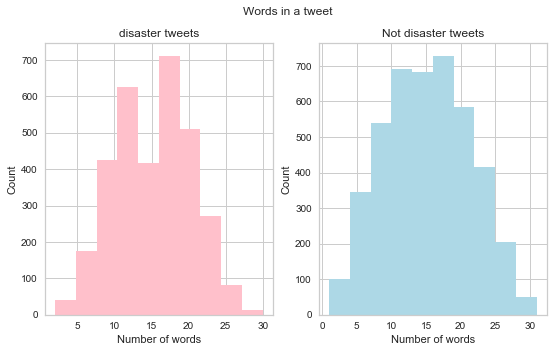

In [391]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(9,5))
tweet_disaster_len=df_tweet[df_tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_disaster_len,color='pink')
ax1.set_title('disaster tweets')
ax1.set_xlabel('Number of words')
ax1.set_ylabel('Count')

tweet_not_disaster_len=df_tweet[df_tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_not_disaster_len,color='lightblue')
ax2.set_title('Not disaster tweets')
ax2.set_xlabel('Number of words')
ax2.set_ylabel('Count')

fig.suptitle('Words in a tweet')
plt.show();

we are going to drop the columns which have missing values as well as ID. 
ID does not add any value to the model that we are about to create.

In [392]:
df_tweet.drop(['id','location', 'keyword'], axis=1, inplace=True)
df_test.drop(['id','location', 'keyword'], axis=1, inplace=True)

In [393]:
df_tweet.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### Cleaning data
-Remove URLs <br>
-Remove HTML tags <br>
-Remove special characters <br>
-etc

In [394]:
# combine train and test dataframes
df_combined = pd.concat([df_tweet, df_test], sort=False, ignore_index=True).reindex()
print(df_combined.shape)

(10880, 2)


In [395]:
def remove_URLs(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html_tags(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punctuations(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def correct_spellings(text):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)


def clean_data(df):
    
    documents = list()
    ps = PorterStemmer()
    #wnl = WordNetLemmatizer()

    for i in range(0, len(df)):

        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(df.loc[i,'text']))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to lowercase
        document = document.lower()

        # lemmatization and stemmer
        # In lemmatization, we can convert the word into the root form of the word. 
        # for exampel, "houses" is converted into "house".
        document = document.split()
        document = [ps.stem(word) for word in document]
        document = ' '.join(document)

        documents.append(document)
    return documents

In [396]:
df_combined['text'] = df_combined['text'].apply(lambda x : remove_URLs(x))
df_combined['text'] = df_combined['text'].apply(lambda x : remove_html_tags(x))
df_combined['text'] = df_combined['text'].apply(lambda x : remove_punctuations(x))
# it takes long time to execute
#df_tweet['text'] = df_tweet['text'].apply(lambda x : correct_spellings(x))
documents = list(clean_data(df_combined))

In [397]:
len(documents)

10880

In [398]:
df_combined[50:60]

,text,target
50,Deputies Man shot before Brighton home set ablaze,1.0
51,Man wife get six years jail for setting ablaze niece\n,1.0
52,SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintendent Lanford Salmon has r,0.0
53,Police Arsonist Deliberately Set Black Church In North CarolinaåÊAblaze,1.0
54,Noches ElBestia AlexisSanchez happy to see my teammates and training hard goodnight gunners,0.0
55,Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen Front in Diyala,1.0
56,TRUCK ABLAZE R21 VOORTREKKER AVE OUTSIDE OR TAMBO INTL CARGO SECTION,1.0
57,Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips Û,0.0
58,They sky was ablaze tonight in Los Angeles Im expecting IG and FB to be filled with sunset shots if I know my peeps,0.0
59,How the West was burned Thousands of wildfires ablaze in California alone climate energy,1.0


In [399]:
# print 10 rows
documents[50:60]

['deputi man shot befor brighton home set ablaz',
 'man wife get six year jail for set ablaz niec',
 'santa cruz ûó head of the st elizabeth polic superintend lanford salmon ha',
 'polic arsonist deliber set black church in north carolinaåêablaz',
 'noch elbestia alexissanchez happi to see my teammat and train hard goodnight gunner',
 'kurd trampl on turkmen flag later set it ablaz while other vandal offic of turkmen front in diyala',
 'truck ablaz r21 voortrekk ave outsid or tambo intl cargo section',
 'set our heart ablaz and everi citi wa gift and everi skylin wa like kiss upon the lip û',
 'they sky wa ablaz tonight in lo angel im expect ig and fb to be fill with sunset shot if know my peep',
 'how the west wa burn thousand of wildfir ablaz in california alon climat energi']

## Converting Text to Numbers

Machines cannot understand the raw text. Machines can only understand numbers. 
Statistical techniques including machine learning can only deal with numbers. 
Therefore, we need to convert our text into numbers.

<ul>   
   <li><b>max_features:</b> Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus</li>
    <li><b>max_df:</b> When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold.</li>
    </ul>

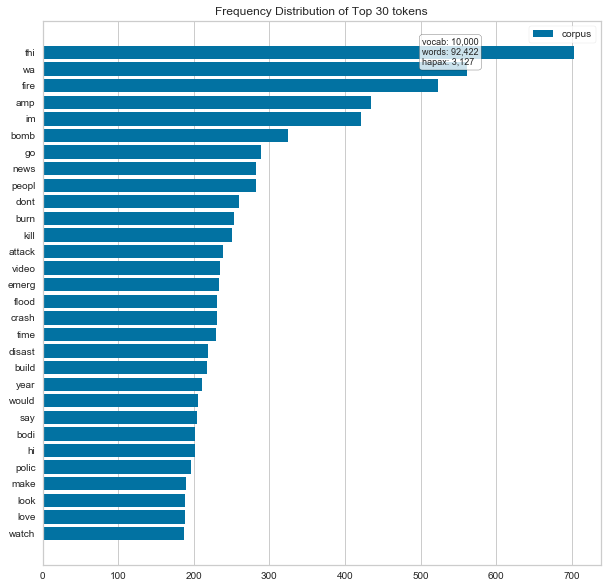

In [400]:
# Find the document term frequency matrix
stopwords = nltk.corpus.stopwords.words('english')

# add some more stop words
newStopWords = ['http','https', 'co', 'via', 'us','like','one','get','new','û','ha']
stopwords.extend(newStopWords)

vectorizer = CountVectorizer(max_features=10000,
                             analyzer='word',
                             max_df=.6,
                             stop_words=stopwords)

X = vectorizer.fit_transform(documents).toarray()

# Get all features (tokens)
features = vectorizer.get_feature_names()

# we can use yellowbrick package for visualization of top 30 tokens
fig, ax = plt.subplots(figsize=(10, 10))
visualizer = FreqDistVisualizer(features=features, n=30, orient='h')
visualizer.fit(X)
visualizer.poof()

In [401]:
tfidfconverter = TfidfTransformer()

X = tfidfconverter.fit_transform(X).toarray()
y = df_tweet['target']

#split data into train and test set
train_set_X = X[:df_tweet.shape[0]]
test_set_X = X[df_tweet.shape[0]:]

In [309]:
X_train, X_test, y_train, y_test = train_test_split(train_set_X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

### Creating the model

In [310]:
rfc = RandomForestClassifier(n_estimators=800, 
                             random_state=42, 
                             max_features='auto')

rfc.fit(X_train, y_train)

# predict for testing data
y_pred_test = rfc.predict(X_test)

# predict for training data
y_pred_train = rfc.predict(X_train)

In [311]:
# test
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

0.7850262697022767
[[1168  170]
 [ 321  625]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      1338
           1       0.79      0.66      0.72       946

   micro avg       0.79      0.79      0.79      2284
   macro avg       0.79      0.77      0.77      2284
weighted avg       0.79      0.79      0.78      2284



In [312]:
# train
print(accuracy_score(y_train, y_pred_train))
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))

0.9866766747982736
[[2987   17]
 [  54 2271]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3004
           1       0.99      0.98      0.98      2325

   micro avg       0.99      0.99      0.99      5329
   macro avg       0.99      0.99      0.99      5329
weighted avg       0.99      0.99      0.99      5329



### Save the Model

In [313]:
#The wb indicates that the file is opened for writing in binary mode
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(rfc,picklefile)

### Load the Model

In [353]:
#The rb indicates that the file is opened for reading in binary mode
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

### Make prediction based on the Loaded model

In [354]:
y_pred_test_2 = model.predict(X_test)

print(confusion_matrix(y_test, y_pred_test_2))
print(classification_report(y_test, y_pred_test_2))
print(accuracy_score(y_test, y_pred_test_2)) 

[[1168  170]
 [ 321  625]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      1338
           1       0.79      0.66      0.72       946

   micro avg       0.79      0.79      0.79      2284
   macro avg       0.79      0.77      0.77      2284
weighted avg       0.79      0.79      0.78      2284

0.7850262697022767


In [404]:
sample_sub = pd.read_csv('dataset/sample.csv')

In [405]:
y_pred_test_data = model.predict(test_set_X)
y_pred_test_data = np.round(y_pred_test_data).astype(int).reshape(3267)

sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(),'text':df_test['text'].values.tolist(),'target':y_pred_test_data})
sub.to_csv('output.csv',index=False)